In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams

In [2]:
import kagglehub
path = kagglehub.dataset_download("moxxis/harry-potter-lstm")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\surya\.cache\kagglehub\datasets\moxxis\harry-potter-lstm\versions\36


In [3]:
with open("C:/Users/surya/.cache/kagglehub/datasets/moxxis/harry-potter-lstm/versions/36/Harry_Potter_all_books_preprocessed.txt") as f:
    text = f.read()

In [4]:
with open("C:/Users/surya/.cache/kagglehub/datasets/moxxis/harry-potter-lstm/versions/36/Harry_Potter_all_char_separated.txt") as f:
    text1 = f.read()

In [5]:
s=set()
for word in text.split():
    temp = set(list(word))
    s.update(temp)
print(len(s))

s=set()
for word in text1.split():
    temp = set(list(word))
    s.update(temp)
print(len(s))

70
75


In [6]:
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
text_processed = text.lower()
replacer = str.maketrans('','',string.punctuation)
text_processed = text_processed.translate(replacer)
text_processed = text_processed.replace("•","")
text_processed = text_processed.replace("■","")
text_processed = text_processed.replace("□","")
text_processed = " ".join([word for word in text_processed.split() if word not in stopwords.words('english')])

In [8]:
word_sequence = text_processed.split()
vocab = set()
d={}
for word in word_sequence:
    if word in d:
        d[word]+=1
        if d[word]>=5 and word not in vocab:
            vocab.add(word)
    else:
        d[word]=1


vocab_d = {}
for i, val in enumerate(vocab):
    vocab_d[val] = i

In [9]:
batch_size = 20
embedding_size = 2
voc_size = len(vocab)
print(batch_size, embedding_size, voc_size)

20 2 9032


In [10]:
j=1
print("Input Word:")
print(word_sequence[j],vocab_d[word_sequence[j]])
print("Context Words:")
print(word_sequence[j-1],word_sequence[j+1])
print(vocab_d[word_sequence[j-1]],vocab_d[word_sequence[j+1]])

Input Word:
lived 4772
Context Words:
boy mr
8509 4309


In [11]:
word_sequence = [word for word in word_sequence if word in vocab]

In [37]:
corpus = " ".join(word_sequence)
from collections import defaultdict
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
word_freqs = defaultdict(int)
for text in corpus.split():
    word_freqs[text]+=1

print(word_freqs)

defaultdict(<class 'int'>, {'boy': 519, 'lived': 89, 'mr': 1281, 'mrs': 890, 'dursley': 86, 'number': 209, 'four': 270, 'privet': 87, 'drive': 118, 'proud': 53, 'say': 883, 'perfectly': 100, 'normal': 109, 'thank': 162, 'much': 1038, 'last': 1055, 'people': 922, 'youd': 288, 'expect': 154, 'involved': 39, 'anything': 730, 'strange': 124, 'mysterious': 34, 'didnt': 1373, 'hold': 179, 'nonsense': 22, 'firm': 20, 'called': 378, 'made': 935, 'drills': 9, 'big': 179, 'man': 474, 'hardly': 164, 'neck': 200, 'although': 95, 'large': 646, 'mustache': 48, 'thin': 184, 'blonde': 25, 'nearly': 331, 'twice': 106, 'usual': 264, 'amount': 51, 'came': 767, 'useful': 70, 'spent': 111, 'time': 1697, 'craning': 16, 'garden': 101, 'spying': 12, 'neighbors': 28, 'small': 473, 'son': 181, 'dudley': 363, 'opinion': 36, 'finer': 5, 'anywhere': 78, 'dursleys': 222, 'everything': 375, 'wanted': 563, 'also': 225, 'secret': 118, 'greatest': 46, 'fear': 146, 'somebody': 149, 'would': 2263, 'discover': 22, 'think'

In [38]:
alphabet = []
for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()
print(alphabet)

['0', '1', '2', '3', '4', '5', '7', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '‘']


In [ ]:
new_vocab = ["<|endoftext|>"] + alphabet.copy()
splits = {word: [c for c in word] for word in word_freqs.keys()}

In [59]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) ==1:
            continue
        for i in range(len(split)-1):
            pair = (split[i], split[i+1])
            pair_freqs[pair]+=freq
    return pair_freqs

In [60]:
def merge_pair(a,b,splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i=0
        while i < len(split)-1:
            if split[i]==a and split[i+1]==b:
                split = split[:i] + [a+b] + split[i+2:]
            else:
                i+=1
        splits[word] = split
    return splits


In [61]:
# pair_freqs = compute_pair_freqs(splits)
# best_pair = ""
# max_freq = None
# for pair, freq in pair_freqs.items():
#     if max_freq is None or max_freq<freq:
#         best_pair = pair
#         max_freq = freq

# print(best_pair)
# print(max_freq)
# merges = best_pair[0]+best_pair[1]
# new_vocab.append(merges)

In [71]:
vocab_size = 5000
merges = {}
for i in range(len(new_vocab),vocab_size):
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq<freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(best_pair[0], best_pair[1], splits)
    merges[best_pair] = best_pair[0]+best_pair[1]
    new_vocab.append(best_pair[0]+best_pair[1])

In [72]:
def tokenize(text):
    splits = [[l for l in word] for word in text.split()]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i=0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i+1] == pair[1]:
                    split = split[:i] + [merge] + split[i+2:]
                else:
                    i+=1
            splits[idx] = split
    return sum(splits, [])

In [78]:
new_vocab = {val:idx for idx, val in enumerate(new_vocab)}

In [88]:
word_sequence_new = []
for word in text_processed.split():
    if word in new_vocab:
        word_sequence_new.append(word)
        continue
    val = word[0]
    for ch in word[1:]:
        if val not in new_vocab:            
            word_sequence_new.append(val[:-1])
            val=ch
        else:
            val+=ch
    if val in new_vocab:
        word_sequence_new.append(val)

In [111]:
skip_grams = []
for i in range(1, len(word_sequence_new)-1):
    if word_sequence_new[i] in new_vocab:
        inp = new_vocab[word_sequence_new[i]]
        context = [new_vocab[word_sequence_new[i-1]], new_vocab[word_sequence_new[i+1]]]
        for w in context:
            skip_grams.append([inp, w])

[[2555, 561], [2555, 228], [228, 2555], [228, 444], [444, 228], [444, 1083]]

In [112]:
np.random.seed(seed=42)

def random_batch(data,size):
    random_inputs=[]
    random_labels=[]
    random_index=np.random.choice(range(len(data)),size, replace=False)
    for i in random_index:
        random_inputs.append(np.eye(voc_size)[data[i][0]])
        random_labels.append(data[i][1])
    return random_inputs, random_labels
test = random_batch(skip_grams[:6], size=3)

In [173]:
X, y = random_batch(skip_grams, size=100)

In [121]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.optimizers import Adam

In [122]:
X = np.array(X)
y=np.array(y)

In [125]:
X.shape

(50, 9032)

In [137]:
target_words, context_words = zip(*skip_grams)
target_words = np.array(target_words, dtype="int32")
context_words = np.array(context_words, dtype="int32")

In [129]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten


embedding_dim = 100 
window_size = 1

target_input = Input(shape=(1,), name="target_input")
context_input = Input(shape=(1,), name="context_input")

target_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="target_embedding")(target_input)
context_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="context_embedding")(context_input)

dot_product = Dot(axes=2)([target_embedding, context_embedding])
output = Flatten()(dot_product)

model = Model(inputs=[target_input, context_input], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy")

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_embedding    │ (None, 1, 100)    │    500,000 │ target_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_embedding   │ (None, 1, 100)    │    500,000 │ context_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ target_embedding… │
│                     │                   │            │ context_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [138]:
labels = np.ones(len(target_words))

# Train the model
model.fit(
    [target_words, context_words],
    labels,
    epochs=10,
    batch_size=64,
    verbose=1
)

Epoch 1/10
21996/21996 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - loss: 3.4922
Epoch 2/10
21996/21996 ━━━━━━━━━━━━━━━━━━━━ 127s 5ms/step - loss: 0.0273
Epoch 3/10
21996/21996 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step - loss: 0.0209
Epoch 4/10
21996/21996 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - loss: 0.0205
Epoch 5/10
21996/21996 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - loss: 0.0209
Epoch 6/10
21996/21996 ━━━━━━━━━━━━━━━━━━━━ 113s 5ms/step - loss: 0.0208
Epoch 7/10
21996/21996 ━━━━━━━━━━━━━━━━━━━━ 113s 5ms/step - loss: 0.0207
Epoch 8/10
21996/21996 ━━━━━━━━━━━━━━━━━━━━ 113s 5ms/step - loss: 0.0208
Epoch 9/10
21996/21996 ━━━━━━━━━━━━━━━━━━━━ 113s 5ms/step - loss: 0.0200
Epoch 10/10
21996/21996 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.0196


In [175]:
model.save("ownword2vech.keras")

In [140]:
embedding_layer  = model.get_layer("target_embedding")
embeddings = embedding_layer.get_weights()[0]

In [156]:
id2word = {v:k for k, v in new_vocab.items()}

In [170]:
#check similar words
import heapq
word_to_check = "voldemort"
check_embedding = embeddings[new_vocab[word_to_check]]
scores = {}
for idx,emb in enumerate(embeddings):
    if idx == new_vocab[word_to_check]:
        continue
    scores[id2word[idx]] = np.dot(emb,check_embedding)
print(scores)
top_10_words = heapq.nlargest(10, scores, key=scores.get)
top_10_words

{'<|endoftext|>': 0.044117462, '0': 2.0530849, '1': 3.0985107, '2': 2.0760777, '3': 2.3003085, '4': 2.348817, '5': 2.514497, '7': 2.3157864, '9': 2.4900954, 'a': 3.7150552, 'b': 2.7043135, 'c': 3.6694067, 'd': 4.5756745, 'e': 4.970172, 'f': 2.6426194, 'g': 4.207453, 'h': 3.6503172, 'i': 3.9118052, 'j': 3.159731, 'k': 3.362634, 'l': 3.9078689, 'm': 3.9302733, 'n': 4.430395, 'o': 3.8403041, 'p': 3.1302686, 'q': -0.0016967274, 'r': 3.776208, 's': 4.0917234, 't': 3.4930437, 'u': 3.2539406, 'v': 2.4421196, 'w': 2.9749217, 'x': 2.454296, 'y': 3.9959972, 'z': 2.7276628, '‘': 3.8106096, 'in': 2.6847951, 'ed': 5.580809, 'ar': 2.914332, 'er': 3.829619, 'ing': 3.9815495, 'on': 3.4306614, 'st': 2.9191, 'ou': 2.4893403, 're': 4.2114406, 'id': 2.65716, 'en': 3.516345, 'an': 3.6046734, 'th': 2.781292, 'le': 3.2358878, 'or': 2.9584413, 'ry': 3.3618102, 'll': 3.1271553, 'har': 3.448671, 'sa': 3.67329, 'harry': 3.8275115, 'es': 4.1367064, 'oo': 2.779492, 'ly': 3.4525137, 'at': 2.8783314, 'se': 4.197999,

['ed', 'still', 'dumbledore', 'said', 'e', 'one', 'ha', 'began', 'back', 'im']

### USING GENSIM

In [15]:
from gensim.utils import simple_preprocess
from smart_open import open
def preprocess_corpus(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as fin, open(output_path, 'w', encoding='utf-8') as fout:
        for line in fin:
            tokens = simple_preprocess(line)
            text_processed = " ".join(tokens)
            replacer = str.maketrans('','',string.punctuation)
            text_processed = text_processed.translate(replacer)
            text_processed = text_processed.replace("•","")
            text_processed = text_processed.replace("■","")
            text_processed = text_processed.replace("□","")
            text_processed = " ".join([word for word in text_processed.split() if word not in stopwords.words('english')])
            fout.write(text_processed+"\n")

preprocess_corpus('C:/Users/surya/.cache/kagglehub/datasets/moxxis/harry-potter-lstm/versions/36/Harry_Potter_all_books_preprocessed.txt','preprocessed.txt')

In [16]:
from gensim.models import Word2Vec

model = Word2Vec(
    corpus_file = 'preprocessed.txt',
    vector_size = 100,
    window = 10,
    min_count = 5,
    workers = 8,
    sg=1,
    epochs=5
)

model.save("harryPw2v.model")

In [22]:
print(model.wv.most_similar('accio',topn=10))

[('reparo', 0.9300787448883057), ('totalusl', 0.9295384287834167), ('exploded', 0.9285722374916077), ('stupefy', 0.9278175234794617), ('expelliarmusv', 0.9264026880264282), ('slashed', 0.9237021207809448), ('motion', 0.923050582408905), ('squealing', 0.9224218726158142), ('aloft', 0.9218666553497314), ('petrificus', 0.9204224944114685)]


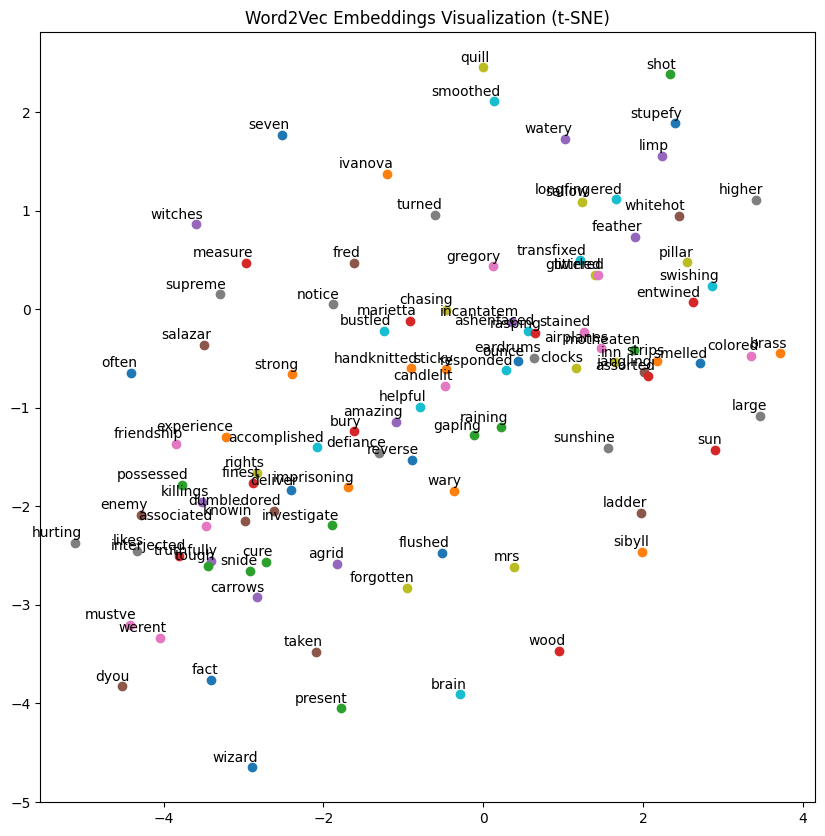

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

words = list(vocab)[:100]
vectors = np.array([model.wv[word] for word in words if word in model.wv])

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# Plot the embeddings
plt.figure(figsize=(10,10))
for i, word in enumerate(words):
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1])
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.title("Word2Vec Embeddings Visualization (t-SNE)")
plt.show()